In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# importing scikit-survival packages
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
# importing self coded package (contains customised and most used fuctions)
from function_utils import *
# importing self coded package (contains customised and most used fuctions)
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, KFold

import eli5
from eli5.sklearn import PermutationImportance

sns.set()
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
#importing the datasets
data = pd.read_csv("../data/preprocess2/data_No_nutrition.csv")
data_nutri = pd.read_csv("../data/preprocess2/data_nutrition.csv")
print("dataset with nutritional features shape is: ", data_nutri.shape)
print("dataset without nutritional features shape is: ", data.shape)

dataset with nutritional features shape is:  (43720, 117)
dataset without nutritional features shape is:  (43720, 54)


In [4]:
data.head(2)

release_year gender  age_year  age_month      race_ethnicity military  \
0          2000   Male        77      926.0  Non-Hispanic White      Yes   
1          2000   Male        49      597.0  Non-Hispanic White      Yes   

                          citizenship        education   maried  \
0  Citizen by birth or naturalization  more_highschool      NaN   
1  Citizen by birth or naturalization  more_highschool  Married   

   num_poeple_houshold  family_income_to_poverty_ratio    2yr_weight  \
0                    1                             5.0  26678.636376   
1                    3                             5.0  91050.846620   

   2yr_weight_mec smoke  LBXTC  LBDTCSI  LBDHDL  LBDHDLSI  LBXTR  LBDTRSI  \
0    28325.384898    no  215.0     5.56    54.0      1.39  128.0     1.45   
1    99445.065735    no  279.0     7.21    42.0      1.08  347.0     3.92   

   LBDLDL  LBDLDLSI  sytolic_blood_presure_x  diatolic_blood_presure_x  \
0   136.0      3.52               100.666667                 56.666667   
1   168.0      4.34               122.000000                 82.666667   

  pulse regularity_x have asthma overweight heart failure background  \
0            Regular         NaN        NaN                       No   
1            Regular         NaN        NaN                       No   

  coronary heart disease background angina/angina pectoris background  \
0                                No                                No   
1                                No                                No   

  heart attack background stroke background thyroid problem background  \
0                      No                No                        NaN   
1                      No                No                        NaN   

  chronic bronchitis background liver condition background  \
0                            No                         No   
1                            No                         No   

  heart attack family background asthma family background  \
0                            NaN                      NaN   
1                            NaN                      NaN   

  diabetes family background diagnosed_diabetes take_insulin prediabetic  \
0                        NaN                 No          NaN         NaN   
1                        NaN                 No           No         NaN   

  diabetes risk       mortstat         ucod_leading diabetes hyperten  \
0           NaN   Assumed Dead  Alzheimer's disease       No       No   
1           NaN  Assumed Alive                  NaN      NaN      NaN   

   permth_int  permth_exm  age_follow_up_end  month_to_release  income_low  \
0       177.0       176.0                 92               5.0     45000.0   
1       191.0       190.0                 65               5.0     75000.0   

   income_up  income_less  income_more  
0    54999.0            0            0  
1        NaN            0            1

In [5]:
data_nutri.head(2)

release_year gender  age_year  age_month      race_ethnicity military  \
0          2000   Male        77      926.0  Non-Hispanic White      Yes   
1          2000   Male        49      597.0  Non-Hispanic White      Yes   

                          citizenship        education   maried  \
0  Citizen by birth or naturalization  more_highschool      NaN   
1  Citizen by birth or naturalization  more_highschool  Married   

   num_poeple_houshold  family_income_to_poverty_ratio    2yr_weight  \
0                    1                             5.0  26678.636376   
1                    3                             5.0  91050.846620   

   2yr_weight_mec smoke  Energy (kcal)  Protein (gm)  Carbohydrate (gm)  \
0    28325.384898    no        2463.00        123.16             350.37   
1    99445.065735    no        2658.14         97.13             253.98   

   Total sugars (gm)  Dietary fiber (gm)  Total fat (gm)  \
0                NaN               36.99           71.95   
1                NaN               17.28          114.52   

   Total saturated fatty acids (gm)  Total monounsaturated fatty acids (gm)  \
0                             24.34                                   26.48   
1                             36.00                                   60.55   

   Total polyunsaturated fatty acids (gm)  Cholesterol (mg)  \
0                                   11.94            313.95   
1                                   11.35            180.57   

   Vitamin E as alpha-tocopherol (mg)  \
0                                 NaN   
1                                 NaN   

   Added alpha-tocopherol (Vitamin E) (mg)  Retinol (mcg)  \
0                                      NaN            NaN   
1                                      NaN            NaN   

   Vitamin A, RAE (mcg)  Alpha-carotene (mcg)  Beta-carotene (mcg)  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   

   Beta-cryptoxanthin (mcg)  Lycopene (mcg)  Lutein + zeaxanthin (mcg)  \
0                       NaN             NaN                        NaN   
1                       NaN             NaN                        NaN   

   Thiamin (Vitamin B1) (mg)  Riboflavin (Vitamin B2) (mg)  Niacin (mg)  \
0                       2.11                          3.25        36.99   
1                       2.62                          3.05        31.23   

   Vitamin B6 (mg)  Total Folate (mcg)  Folic acid (mcg)  Food folate (mcg)  \
0             2.90              528.29               NaN                NaN   
1             2.92              749.83               NaN                NaN   

   Folate, DFE (mcg)  Vitamin B12 (mcg)  Added vitamin B12 (mcg)  \
0                NaN               8.68                      NaN   
1                NaN               6.66                      NaN   

   Vitamin C (mg)  Vitamin K (mcg)  Calcium (mg)  Phosphorus (mg)  \
0          119.12              NaN        925.37          1974.57   
1          112.19              NaN       1626.38          1811.55   

   Magnesium (mg)  Iron (mg)  Zinc (mg)  Copper (mg)  Sodium (mg)  \
0          502.25      37.29      41.61         2.08          NaN   
1          367.72      27.22      10.17         1.95          NaN   

   Potassium (mg)  Selenium (mcg)  Caffeine (mg)  Theobromine (mg)  \
0         4672.48          123.20         530.45            177.72   
1         3743.15          104.65           0.00              0.00   

   Alcohol (gm)  Moisture (gm)  SFA 4:0 (Butanoic) (gm)  \
0          0.00            NaN                     0.17   
1         34.56            NaN                     1.24   

   SFA 6:0 (Hexanoic) (gm)  SFA 8:0 (Octanoic) (gm)  SFA 10:0 (Decanoic) (gm)  \
0                     0.10                     0.06                      0.18   
1                     0.57                     0.37                      0.80   

   SFA 12:0 (Dodecanoic) (gm)  SFA 14:0 (Tetradecanoic) (gm)

* In the study our Inclusion criteria were age more thand 20 years old at the time of interview with no prior CVD(cardiovascular desease) history.  
To match these criterion we delete all observations with CVD background

In [6]:
background= ["heart failure background", "coronary heart disease background", "heart attack background", "stroke background"]
value = "Yes"
for col in background:
    data = del_observation(data, col, value)
    data_nutri = del_observation(data_nutri, col, value)

data = data.drop(background, axis =1)
data_nutri = data_nutri.drop(background, axis =1)
print("dataset with nutritional features shape is: ", data_nutri.shape)
print("dataset without nutritional features shape is: ", data.shape)

dataset with nutritional features shape is:  (39097, 113)
dataset without nutritional features shape is:  (39097, 50)


* Here we build the event (death from CVD) column   
We will treat all the other as censored, ie we push permth_int to 


In [7]:
def event(val):
    """
        return 1 if val in a CVD
    """
    if val == 'Disease of heart' or val == 'Cerebrovascular diseases':
        return 1
    return 0


def permth_int_censored_obs(df, i):
    """
        conpute the censored time (ie time from inteview to the end of study in 2015)
    """
    months = df["month_to_release"][i] + (2015 - df["release_year"][i])*12
    return months

def permth_int_censored_all(df):
    """
        transform observed deaths which cause is different from CVDto censored observations
    """
    df["time"] = df.permth_int.values
    for i in df.index:
        if pd.notna(data.ucod_leading[i]) and df.ucod_leading[i] not in {"Disease of heart", "Cerebrovascular diseases"}:
            df.loc[i]["time"] = permth_int_censored_obs(df, i)
    return df

# here we build the event (death from CVD) column 
# we will treat all the other as censored, ie we push permth_int to 
# the columns CVD constaint CVD death Events
data["CVD"] = data.ucod_leading.apply(event)
data_nutri["CVD"] = data_nutri.ucod_leading.apply(event)

# the columns time contains the permth_int recoded as explained above
data = permth_int_censored_all(data)
data_nutri = permth_int_censored_all(data_nutri)

# we drop columns we dont need
cols = ["mortstat","ucod_leading","diabetes","hyperten","permth_int","permth_exm","age_follow_up_end"]
data = data.drop(cols, axis = 1)
data_nutri = data_nutri.drop(cols, axis=1)

In [8]:
event = "CVD"
time = "time"

# Some trends

In [9]:
#we fix the radom_state for all teh study to have reproductible results
rand_state = 42
train, test = split_test_train(data, "release_year", .3, random_state= rand_state)

In [10]:
train.shape, test.shape

((27367, 45), (11730, 45))

### Survival fonction estimation

In [11]:
train.head(3)

release_year  gender  age_year  age_month      race_ethnicity military  \
1          2000    Male        49      597.0  Non-Hispanic White      Yes   
2          2000  Female        59      712.0  Non-Hispanic Black       No   
3          2000    Male        43      518.0  Non-Hispanic Black      Yes   

                          citizenship        education     maried  \
1  Citizen by birth or naturalization  more_highschool    Married   
2  Citizen by birth or naturalization  less_highschool    Married   
3  Citizen by birth or naturalization       highschool  Separated   

   num_poeple_houshold  family_income_to_poverty_ratio    2yr_weight  \
1                    3                             5.0  91050.846620   
2                    1                             NaN  22352.088620   
3                    1                             NaN  21071.164059   

   2yr_weight_mec smoke  LBXTC  LBDTCSI  LBDHDL  LBDHDLSI  LBXTR  LBDTRSI  \
1    99445.065735    no  279.0     7.21    42.0      1.08  347.0     3.92   
2    25525.423409    no  245.0     6.34   105.0      2.73   62.0     0.70   
3    22445.808572   yes  140.0     3.62    51.0      1.31   45.0     0.51   

   LBDLDL  LBDLDLSI  sytolic_blood_presure_x  diatolic_blood_presure_x  \
1   168.0      4.34               122.000000                 82.666667   
2   127.0      3.28               125.333333                 80.000000   
3    80.0      2.07               145.333333                 96.000000   

  pulse regularity_x have asthma overweight angina/angina pectoris background  \
1            Regular         NaN        NaN                                No   
2            Regular         NaN        NaN                                No   
3            Regular         NaN        NaN                                No   

  thyroid problem background chronic bronchitis background  \
1                        NaN                            No   
2                        NaN                            No   
3                        NaN                            No   

  liver condition background heart attack family background  \
1                         No                            NaN   
2                         No                            NaN   
3                        NaN                            NaN   

  asthma family background diabetes family background diagnosed_diabetes  \
1                      NaN                        NaN                 No   
2                      NaN                        NaN                 No   
3                      NaN                        NaN                 No   

  take_insulin prediabetic diabetes risk  month_to_release  income_low  \
1           No         NaN           NaN               5.0     75000.0   
2           No         NaN           NaN               5.0         NaN   
3           No         NaN           NaN               5.0         NaN   

   income_up  income_less  income_more  CVD   time  
1        NaN            0            1    0  191.0  
2        NaN            0            0    0  200.0  
3        NaN            0            0    0  196.0

In [12]:
def survival_funtion(df, event, time, axes):
    time, survival_prob = kaplan_meier_estimator(df[event].apply(bool), df[time])
    axes.step(time, survival_prob, where="post")
    axes.set_ylabel("est. probability of survival $\hat{S}(t)$")
    axes.set_xlabel("time $t$")

def plot_kaplan_col(df, col, event, axes):
    for val in df[col].dropna().unique():
        survival_funtion(df[df[col] == val], event, time, axes)
        axes.legend(df[col].unique())

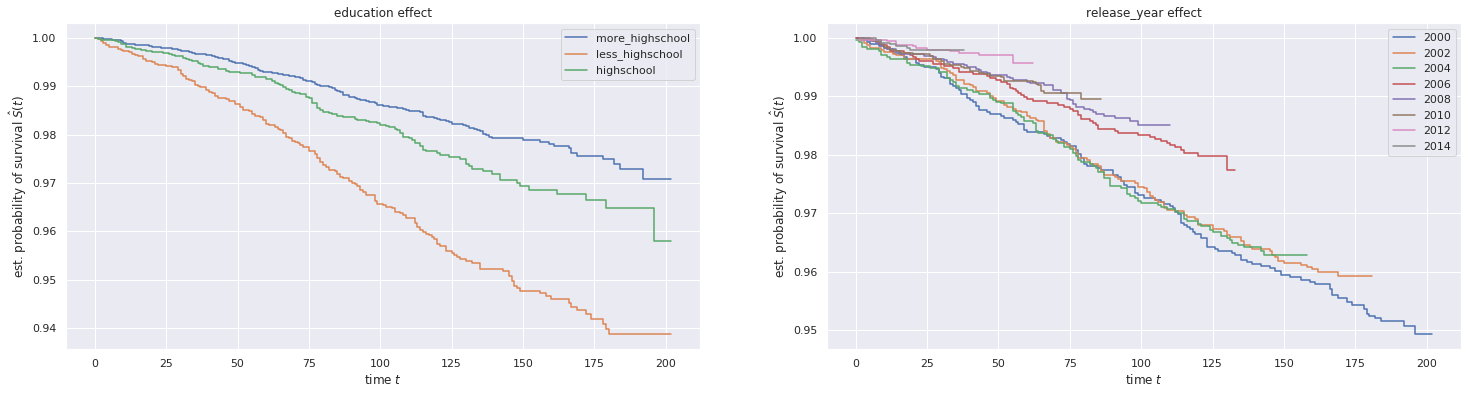

In [13]:
features = ["education","release_year"]
nrow = 1
ncol = 2
s = 0
f, axes = plt.subplots(nrow, ncol, figsize=(25, 6), sharex='row')

for j in range(ncol):
    plot_kaplan_col(train, features[s] , event, axes[j])
    axes[j].set_title("%s effect"%features[s])  
    s +=1


* On the first graph we can see that there are three distinct profiles.
Indeed the chances for an individual to die of a cardiovascular disease decrease with the level of education.
thus an individual level *less_highschool* will have twice as much chance of dying of a cardiovascular disease individual of level *more_highschool*

*  The second one allows me to observe the effect of censorship during the different years For the years 1999 à 2004 the trends are similar:  the survival curves are very close together.
As for the other years we are getting closer to the end of the study so the time is shorter, And the chances of the phenomenon being observed are smaller


#### Classical cardivascular risk factors effects

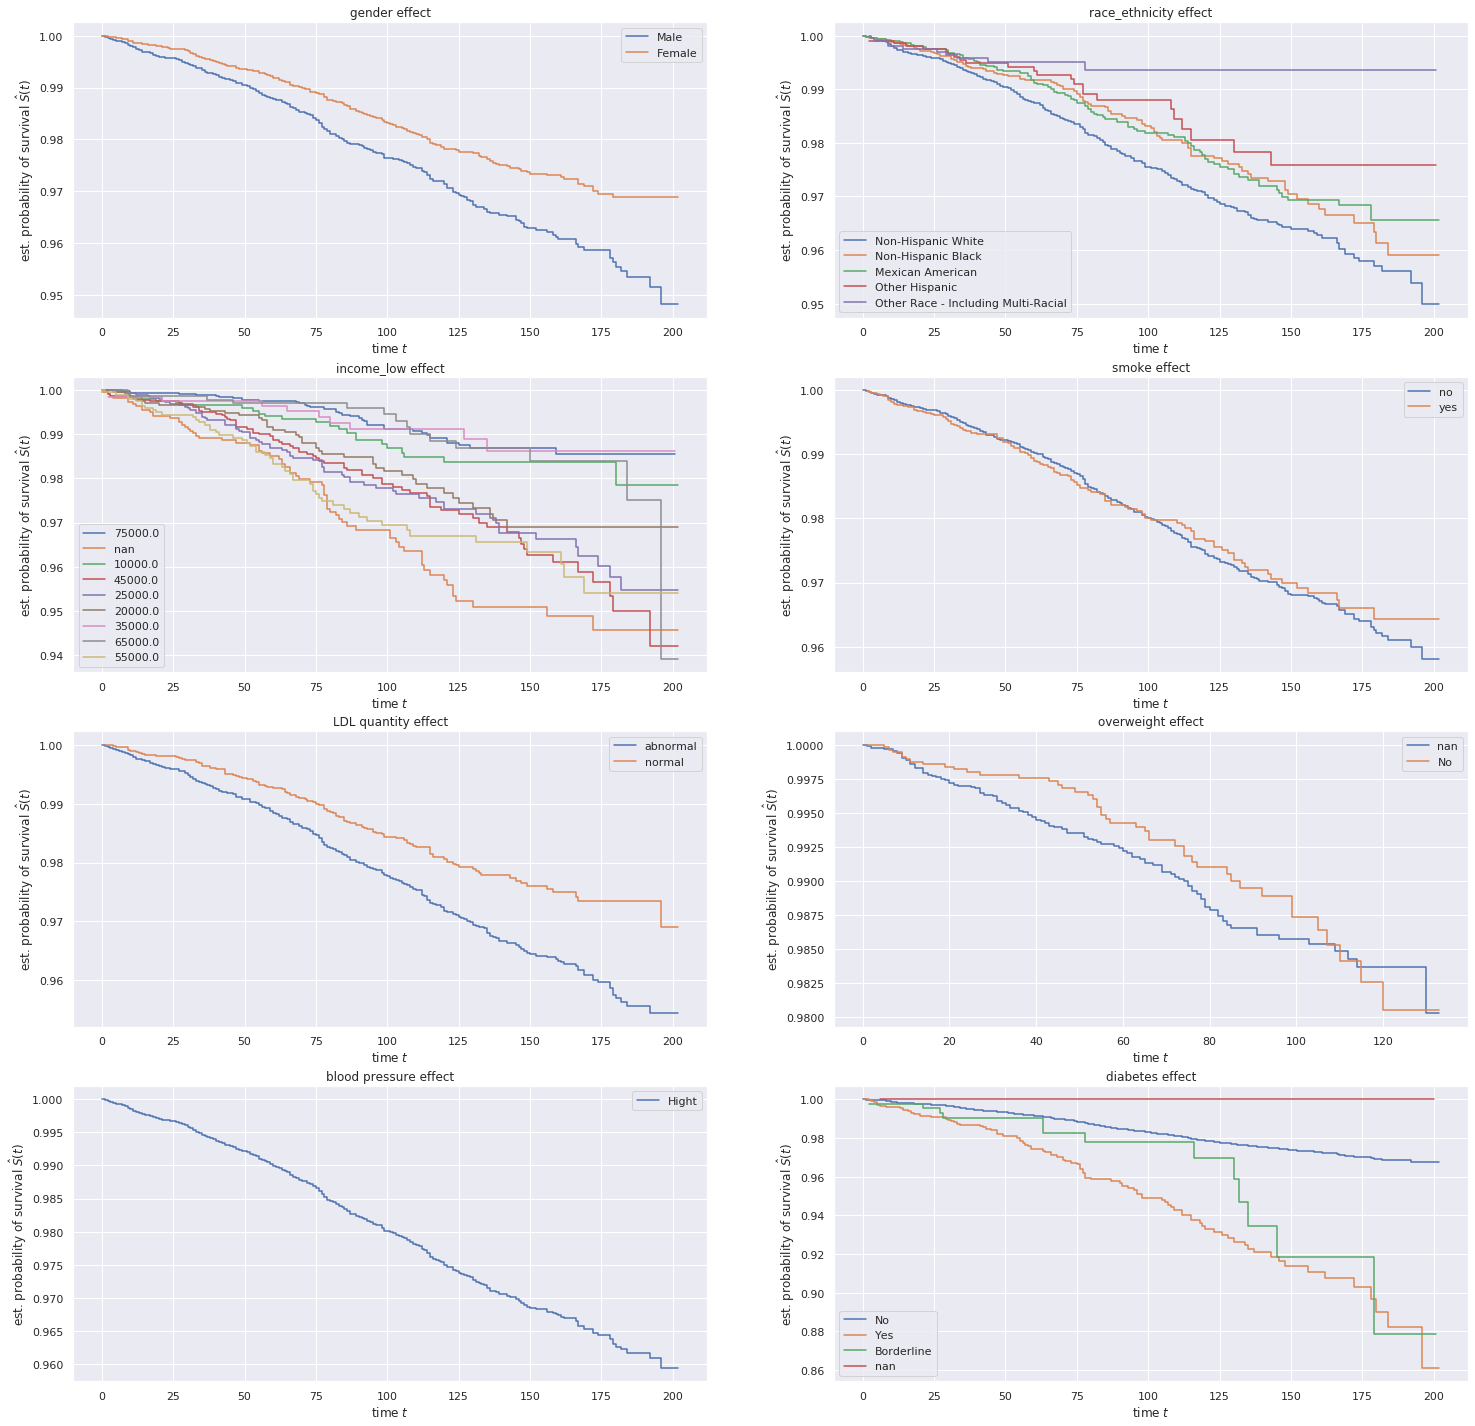

In [14]:

temp = train.copy()
temp["LDL quantity"] = temp["LBDLDL"].apply(str)
for i in temp.index:
    if temp.gender[i] == "Female":
        if temp["LBDLDL"][i] <= 150:
            temp["LDL quantity"][i] = "normal"
        else:
            temp["LDL quantity"][i] = "abnormal"
    elif temp["gender"][i] == "Male":
        if temp["LBDLDL"][i] <= 160:
            temp["LDL quantity"][i] = "normal"
        else:
            temp["LDL quantity"][i] = "abnormal"

temp["blood pressure"] = temp["diatolic_blood_presure_x"].apply(str)
for i in temp.index:
    if temp.sytolic_blood_presure_x[i] <120 and temp.diatolic_blood_presure_x[i] < 80:
        temp["blood pressure"] = "Normal"
    elif temp.sytolic_blood_presure_x[i] < 130 and temp.diatolic_blood_presure_x[i] < 80:
        temp["blood pressure"] = "Elevated"
    elif temp.sytolic_blood_presure_x[i] >=130 or temp.diatolic_blood_presure_x[i] > 80:
        temp["blood pressure"] = "Hight"

temp['diabetes'] = temp["diagnosed_diabetes"].apply(str)
for i in temp.index:
    if temp["diagnosed_diabetes"][i] == 'yes':
        temp["diabetes"][i] = "diagnosed_diabetes"
    elif temp["prediabetic"][i] == 'yes':
        temp["diabetes"][i] = "prediabetic"


nrow = 4
ncol = 2
s = 0
features = ["gender","race_ethnicity", "income_low","smoke", "LDL quantity", "overweight", "blood pressure", "diabetes"]
f, axes = plt.subplots(nrow, ncol, figsize=(25, 25))
for i in range(nrow):
    for j in range(ncol):
        plot_kaplan_col(temp, features[s] , event, axes[i,j])
        axes[i,j].set_title("%s effect"%features[s])
        s +=1

* Here we continue our study of the impact of classical CVD risk factors on the Extimed survival curve.  
The effect of smoke on the survival rate seems to be neutral according to graph *smoking effet*

* The graph *gender effect* confirms the effect of gender already observed in the literature : men are more likely to die of CVD than women.
The same applies to the effect of weight diabete and LDL

*  A strange fact to note is the similarity between the LDL quality effect and gender effect graphs on the one hand and the blood pressure effect and smoke effect graphs on the other. This underlies a certain correlation between these variables  
Maybe the people with abnormal LDL levels are mostly men.

* In terms of race, there are also some trends, in fact the risks are greater and for white non-Hispanics, Followed by Mexican-Americans and non-Hispanic blacks

## **Modeling**

Here we will build some models which aim at predictique the CVD mortality. Our goal is to try check how nutritional data can help improve CVD death prediction.  
as we are dealing with survival analysis, we will stars by build a Cox-model, to then continue towards more complex like Gradient boosting for survival analysis.  
the models efficiency will be assessed, with concordance index and  receiver operating characteristics curve (ROC curve) especially cumulative_dynamic_auc .

we will use Concordance index for right-censored data (concordance_index_ipcw ) which is not biaised the the censoring times in the test data, on the contrary of Harrell's estimator of the c index

### **Data without nutritional features**

**preprocessing**

As in the previous study we randomly sample 70 percent of the data on each wave to form a training set and   
the remaining 30 percent will be used to verify the effectiveness of our future model. 

In [15]:
train, test = split_test_train(data, "release_year", .3, random_state= rand_state)

train  test
gender CVD             
Female 0    14193  6166
       1      237   110
Male   0    12640  5298
       1      297   156

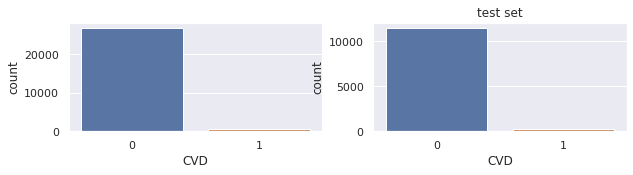

In [16]:
f, axes = plt.subplots(1, 2, figsize=(10, 2), sharex='row')
sns.countplot(data=train, x='CVD', ax=axes[0])
sns.countplot(data=test, x='CVD', ax=axes[ 1]).set_title("test set")

a = train.groupby(['gender', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "train"})
b = test.groupby(['gender', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "test"})
pd.concat([a,b], axis=1)

we can see that the data is really imbalenced, evaluation should take ccensorship effect.  
all gender are reppresented in both test and training set. same applies to races (see bellow).

In [17]:
a = train.groupby(['race_ethnicity', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "train"})
b = test.groupby(['race_ethnicity', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "test"})
pd.concat([a,b], axis=1)

train  test
race_ethnicity                      CVD             
Mexican American                    0     4988  2184
                                    1      102    43
Non-Hispanic Black                  0     5633  2249
                                    1      101    59
Non-Hispanic White                  0    12080  5259
                                    1      297   141
Other Hispanic                      0     2074   909
                                    1       24    13
Other Race - Including Multi-Racial 0     2058   863
                                    1       10    10

* Feature extraction 

In [18]:
# we extract some features
# qualifying the blood presure and LDL level
def ldl(df):
    temp = df.copy()
    temp["LDL quantity"] = temp["LBDLDL"].apply(str)
    for i in temp.index:
        if temp.gender[i] == "Female":
            if temp["LBDLDL"][i] <= 150:
                temp["LDL quantity"][i] = "0"
            else:
                temp["LDL quantity"][i] = "1"
        elif temp["gender"][i] == "Male":
            if temp["LBDLDL"][i] <= 160:
                temp["LDL quantity"][i] = "0"
            else:
                temp["LDL quantity"][i] = "1"
    temp["LDL quantity"] = temp["LDL quantity"].apply(int)
    return temp


train_encoded = ldl(train)
test_encoded = ldl(test)

#we make a one-hot encodieng
train_encoded = pd.get_dummies(train_encoded, drop_first=True)
test_encoded = pd.get_dummies(test_encoded, drop_first=True)

imp = IterativeImputer(random_state=rand_state)
y = train_encoded[["CVD", "time"]].values
x = train_encoded.drop(["CVD", "time"], axis = 1)
col = x.columns
x = imp.fit_transform(x.values)
train_encoded = pd.DataFrame(data = x, columns=col)
train_encoded["time"] = y[:,1]
train_encoded["CVD"] = y[:,0]

# we use the imputer obtained while imputing train_encoded to impute test_encoded dataset
y_test = test_encoded[["CVD", "time"]].values
X_test = imp.transform(test_encoded.drop(["CVD", "time"], axis = 1))
test_encoded = pd.DataFrame(data = X_test, columns= col)
test_encoded["time"] = y_test[:,1]
test_encoded["CVD"] = y_test[:,0]

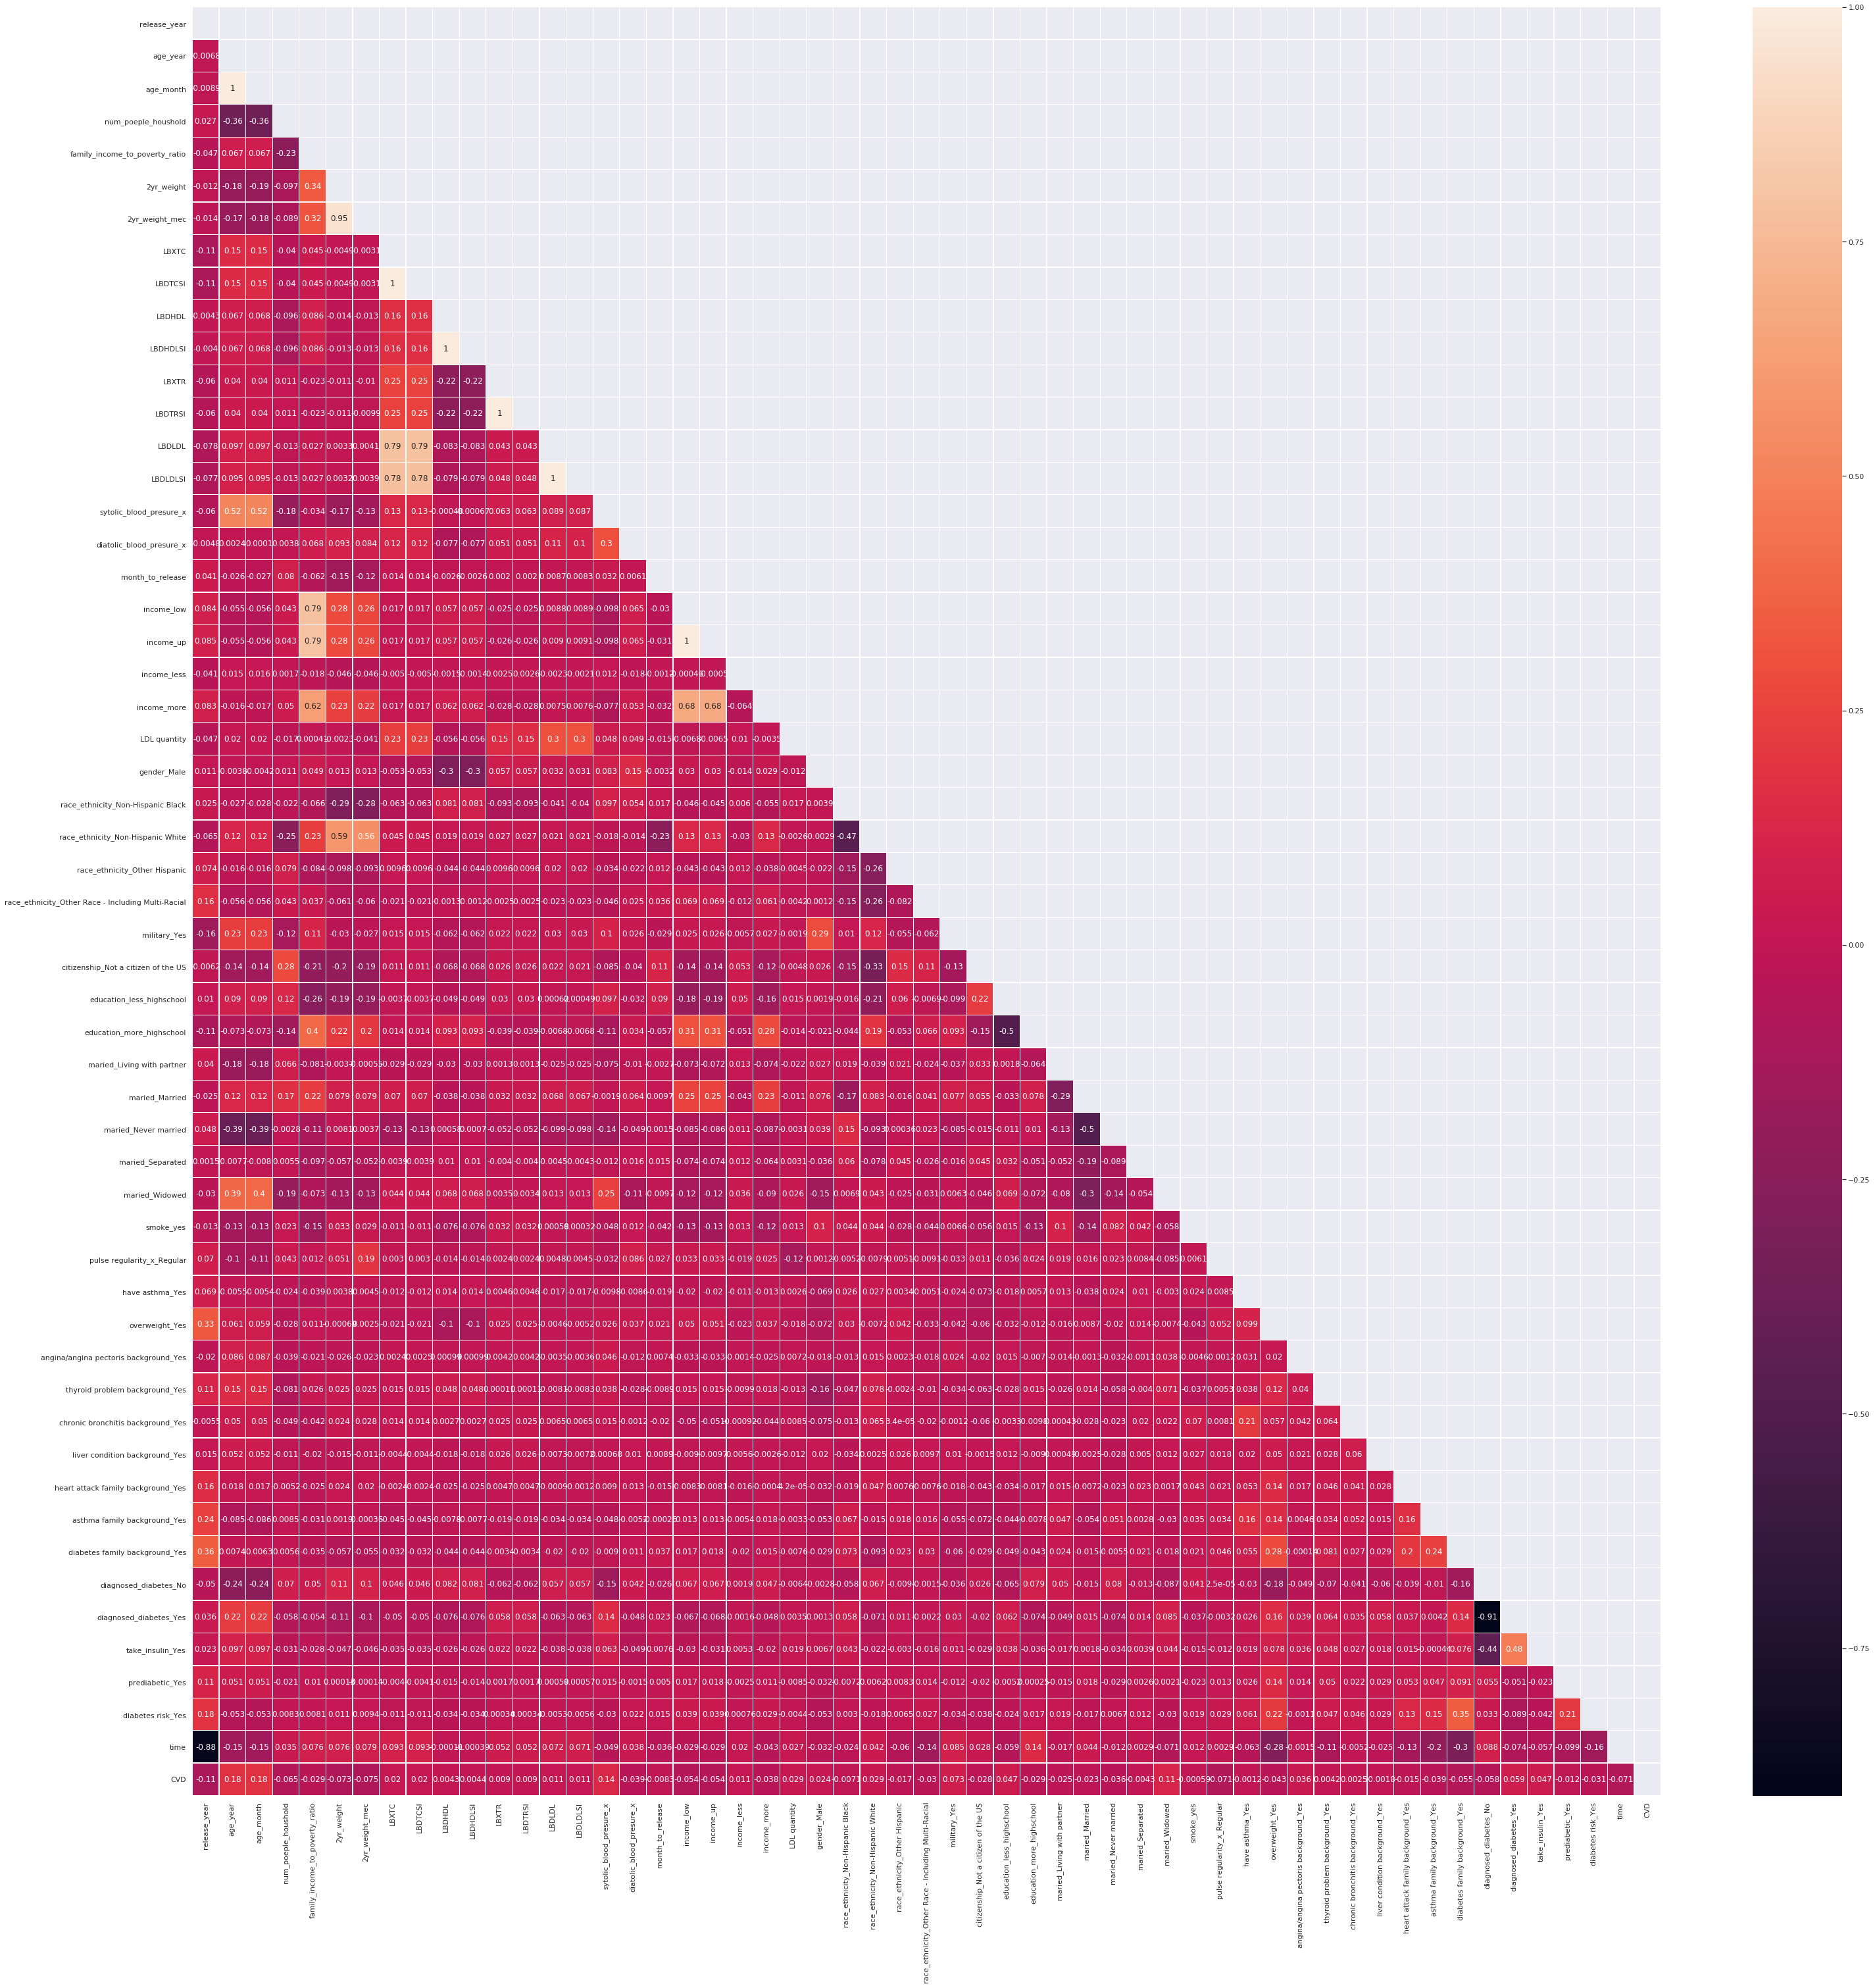

In [19]:
def correlation_matrix(df, figure_size, text_fontsize):
    fig = plt.figure(figsize=figure_size)
    corrmat = df.corr()
    mask = np.zeros_like(corrmat)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corrmat, vmax=1, linewidths=.3, mask = mask , annot=True);

correlation_matrix(train_encoded, (50,50), text_fontsize=10)

On the correlation matrix one can observe that some variable are highly correlated more thant 90%:
- release_year and time,
- 2yr_weight_mec and 2yr_weight,
- LBDTCSI  and LBDTC,
- LBDTRSI  and LBDTR ,
- LBDHDLSI  and LBDHDL, 
- LBDLDLSI and LBDLDL, 
- income_up diagnosed_diabetes_No  and diagnosed_diabetes_Yes,  
- age_year  and age month

therefore we will chose delete some: *release_year, 2yr_weight_mec, LBDTCSI, LBDTRSI, LBDHDLSI, LBDLDLSI, income_up diagnosed_diabetes_No, age_year*


In [20]:
train_encoded = train_encoded.drop(["release_year", "2yr_weight_mec", "LBDTCSI", "LBDTRSI","LBDHDLSI", "LBDLDLSI", "income_up","diagnosed_diabetes_No", "age_year"], axis=1)
test_encoded = test_encoded.drop(["release_year", "2yr_weight_mec", "LBDTCSI", "LBDTRSI","LBDHDLSI", "LBDLDLSI", "income_up","diagnosed_diabetes_No", "age_year"], axis=1)

In [21]:
train_encoded.time.max(), test_encoded.time.max()

(202.0, 202.0)

In [22]:
# to use the cumulative_dynamic_au all training time need to be in the test time range
m = test_encoded.time.max()
train_encoded = del_observation(train_encoded, 'time',m)

In [38]:
train_encoded.time.max(), test_encoded.time.max()

(201.0, 202.0)

In [23]:
y_train = np.array( [tuple(x) for x in train_encoded[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_train = train_encoded[event].apply(bool).values
T_train = train_encoded[time].values
X_train = train_encoded.drop([event, time], axis = 1)

y_test = np.array( [tuple(x) for x in test_encoded[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_test = test_encoded[event].apply(bool).values
T_test = test_encoded[time].values
X_test = test_encoded.drop([event, time], axis = 1).values

**Fist models**

In [24]:
# Cox proportional hazards model
coxph = CoxPHSurvivalAnalysis()

# gradient boosting for survival analysis model
gbs = GradientBoostingSurvivalAnalysis()

In [25]:
coxph.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [27]:
gbs.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                                 learning_rate=0.1, loss='coxph', max_depth=3,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1,
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None,
                                 subsample=1.0, verbose=0)

In [29]:
models= {'CoxPHModel':coxph,"GradientBoostingSurvivalAnalysis": gbs}
for model in models.keys():
    prediction = models[model].predict(X_test)
    result = concordance_index_ipcw(y_train, y_test, prediction)
    print('%s concordance_index_ipcw C-index: %.2f'%(model, result[0]))

CoxPHModel concordance_index_ipcw C-index: 0.87
GradientBoostingSurvivalAnalysis concordance_index_ipcw C-index: 0.83


**parameter tuning**

In [31]:
train_encoded.shape
train_sampled = train_encoded.sample(frac=.25, random_state = rand_state)
train_sampled.CVD.sum()

137.0

In [32]:
#because of the computation time we optimise on a subsample of the total train set
y_train_s = np.array( [tuple(x) for x in train_sampled[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_train_s = train_sampled[event].apply(bool).values
T_train_s = train_sampled[time].values
X_train_s = train_sampled.drop([event, time], axis = 1)

In [33]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
gbs_best = GradientBoostingSurvivalAnalysis()
gns_cv = GridSearchCV(gbs_best,{"max_depth": [3, 5], "n_estimators":[50, 100, 200]},
                      cv=cv, verbose=3, n_jobs=-1).fit(X_train_s, y_train_s)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished


In [34]:
pd.DataFrame(gns_cv.cv_results_).sort_values("mean_test_score", ascending = False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5      59.338063      6.053682         0.011411        0.000664   
2      77.388132      2.983145         0.017939        0.008888   
4      40.340950      0.884618         0.011085        0.002331   
1      39.135636      0.495875         0.012114        0.000448   
0      19.647837      0.930781         0.009636        0.000125   

  param_max_depth param_n_estimators                                 params  \
5               5                200  {'max_depth': 5, 'n_estimators': 200}   
2               3                200  {'max_depth': 3, 'n_estimators': 200}   
4               5                100  {'max_depth': 5, 'n_estimators': 100}   
1               3                100  {'max_depth': 3, 'n_estimators': 100}   
0               3                 50   {'max_depth': 3, 'n_estimators': 50}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
5           0.870123           0.822528           0.807646         0.833436   
2           0.881218           0.802446           0.808930         0.830868   
4           0.858773           0.813221           0.808710         0.826904   
1           0.872188           0.807812           0.793111         0.824375   
0           0.869681           0.800669           0.790455         0.820272   

   std_test_score  rank_test_score  
5        0.026646                1  
2        0.035705                2  
4        0.022613                3  
1        0.034341                4  
0        0.035189                5

**model performance**

In [35]:
gbs_best = gns_cv.best_estimator_
gbs_best.fit(X_train, y_train)
prediction_gbs = gbs_best.predict(X_test)
result2 = concordance_index_ipcw(y_train, y_test, prediction_gbs)
print('%s concordance_index_ipcw C-index: %.2f'%(model, result2[0]))

GradientBoostingSurvivalAnalysis concordance_index_ipcw C-index: 0.87


In [70]:
prediction_cox = coxph.predict(X_test)

In [132]:
def plot_dynamic_auc(y_train, y_test, prediction,time, ax, title = None):
    x_auc, x_mean_auc = cumulative_dynamic_auc(y_train, y_test, prediction,time)
    x_mean_auc = np.nanmean(x_auc)
    ax.plot(range(202), x_auc, marker="o")
    ax.axhline(x_mean_auc, linestyle="--")
    ax.set_xlabel("days from enrollment")
    ax.set_ylabel("time-dependent AUC")
    ax.set_title(title)


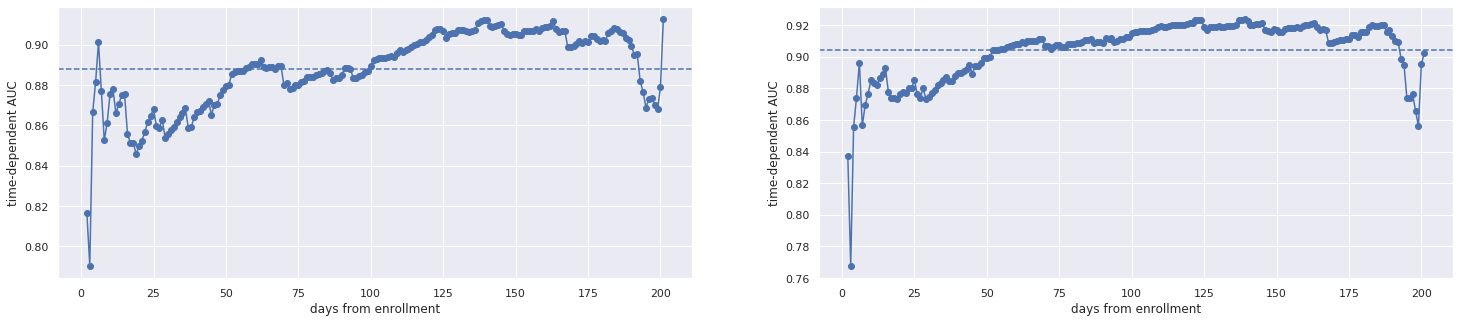

In [79]:
f, ax = plt.subplots(1, 2, figsize=(25, 5), sharex='row')
plot_dynamic_auc(y_train, y_test, prediction_gbs,range(202), ax[0])
plot_dynamic_auc(y_train, y_test, prediction_cox,range(202), ax[1])

* The plot shows that the gradient boosting model is doing quite well on average with an AUC of ~0.89 (dashed line),  
but the traditional Cox proportional hazards model has beter performance with an average with an AUC of ~0.905

* However, there is a clear difference in performance between the first, last time range, and the midle time range.   
Performance decreases up to about 180 days from enrollment, but quickly drops thereafter. Thus, we can conclude that  
the model is less effective in predicting death past 180 days.  

* In the same way, performance is also struggling to increase during the first 30 months. we can then conclude   
that the model is less effective in predicting death first 30 days.  

**feature importance**

In [89]:
feature_names = train_encoded.columns[:-2].tolist()
perm = PermutationImportance(coxph, n_iter=15, random_state=rand_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

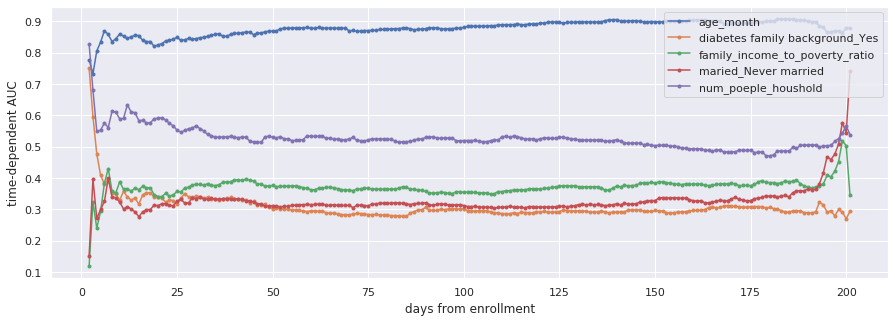

In [108]:
features =("age_month", "diabetes family background_Yes", "family_income_to_poverty_ratio","maried_Never married", "num_poeple_houshold")
plt.figure(figsize=(15, 5))
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, range(202))
    plt.plot(range(202), auc, marker=".", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

for i, col in enumerate(features):
    plot_cumulative_dynamic_auc(X_test[:, i], col)
    ret = concordance_index_ipcw(y_train, y_test, X_test[:, i], tau=range(202)[-1])

### **Data with nutritional features**

**preprocessing**

In [110]:
rand_state = 42
train, test = split_test_train(data_nutri, "release_year", .3, random_state= rand_state)

train  test
gender CVD             
Female 0    14193  6166
       1      237   110
Male   0    12640  5298
       1      297   156

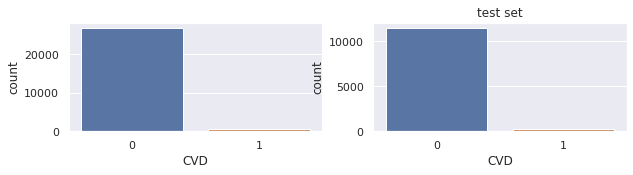

In [111]:
f, axes = plt.subplots(1, 2, figsize=(10, 2), sharex='row')
sns.countplot(data=train, x='CVD', ax=axes[0])
sns.countplot(data=test, x='CVD', ax=axes[ 1]).set_title("test set")

a = train.groupby(['gender', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "train"})
b = test.groupby(['gender', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "test"})
pd.concat([a,b], axis=1)

In [112]:
a = train.groupby(['race_ethnicity', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "train"})
b = test.groupby(['race_ethnicity', "CVD"]).count()[["release_year"]].rename(columns = {"release_year": "test"})
pd.concat([a,b], axis=1)

train  test
race_ethnicity                      CVD             
Mexican American                    0     4988  2184
                                    1      102    43
Non-Hispanic Black                  0     5633  2249
                                    1      101    59
Non-Hispanic White                  0    12080  5259
                                    1      297   141
Other Hispanic                      0     2074   909
                                    1       24    13
Other Race - Including Multi-Racial 0     2058   863
                                    1       10    10

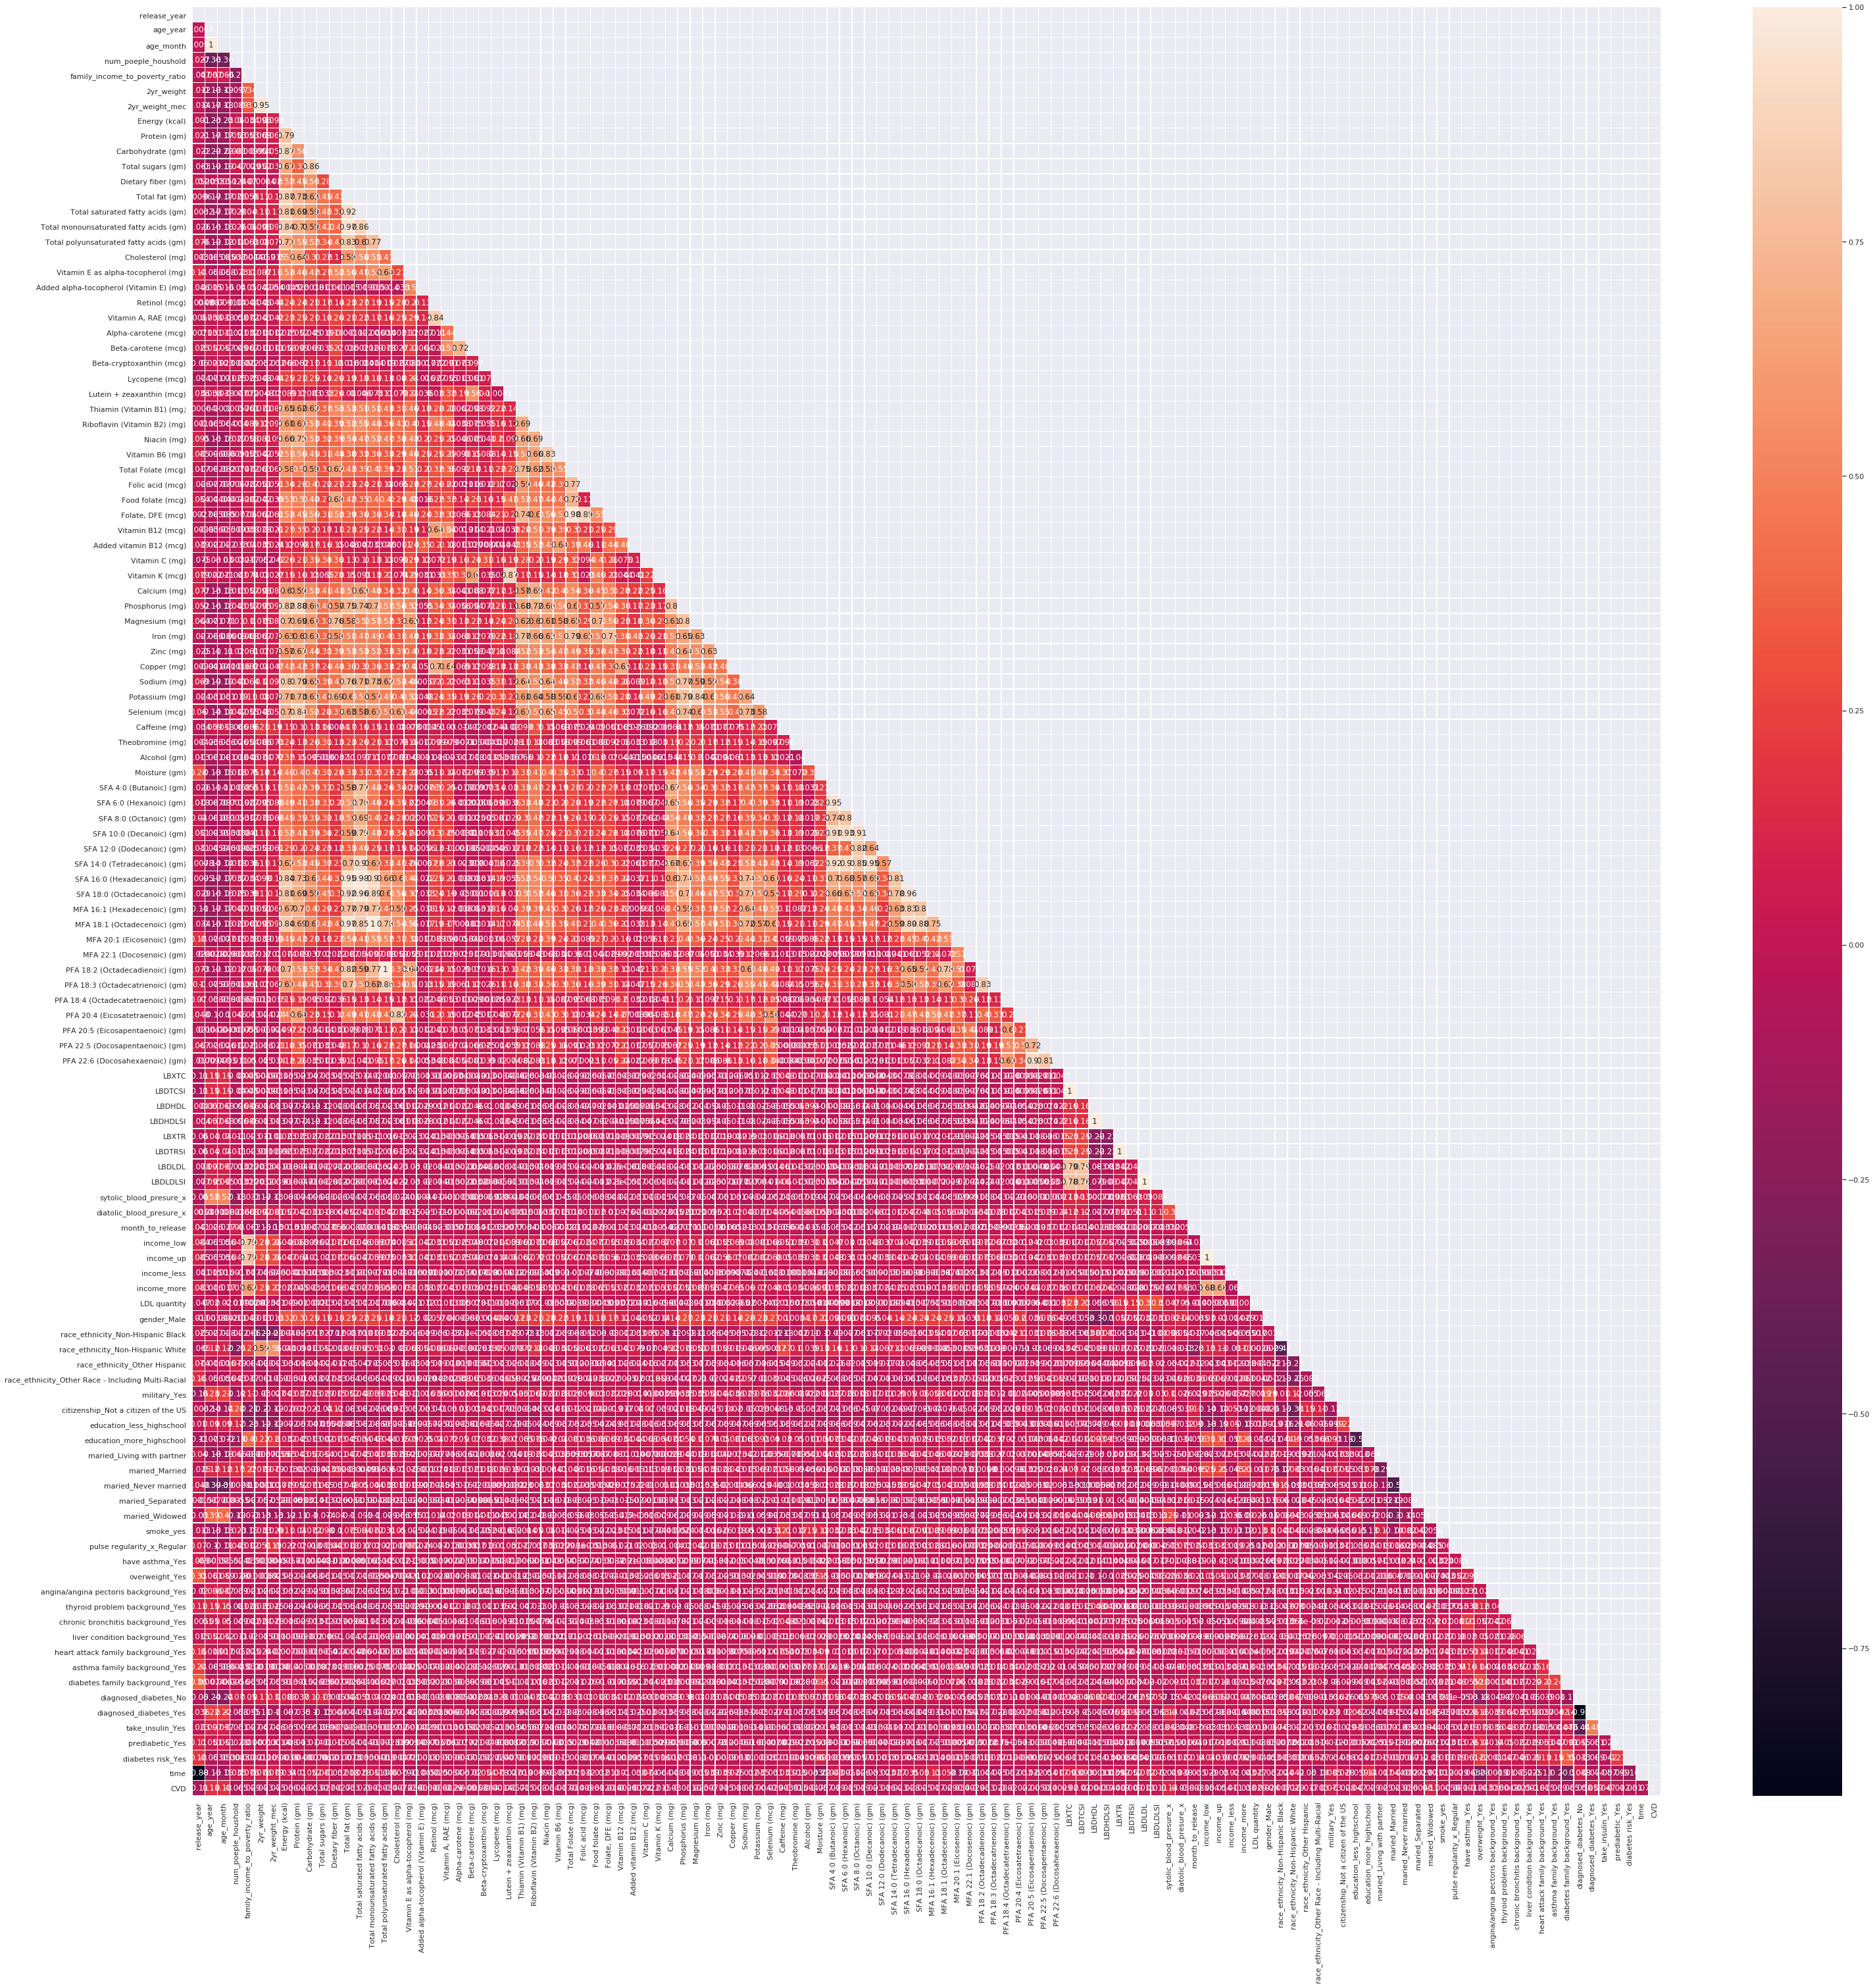

In [114]:
# we extract some features
# qualifying the blood presure and LDL level
def ldl(df):
    temp = df.copy()
    temp["LDL quantity"] = temp["LBDLDL"].apply(str)
    for i in temp.index:
        if temp.gender[i] == "Female":
            if temp["LBDLDL"][i] <= 150:
                temp["LDL quantity"][i] = "0"
            else:
                temp["LDL quantity"][i] = "1"
        elif temp["gender"][i] == "Male":
            if temp["LBDLDL"][i] <= 160:
                temp["LDL quantity"][i] = "0"
            else:
                temp["LDL quantity"][i] = "1"
    temp["LDL quantity"] = temp["LDL quantity"].apply(int)
    return temp


train_encoded = ldl(train)
test_encoded = ldl(test)

#we make a one-hot encodieng
train_encoded = pd.get_dummies(train_encoded, drop_first=True)
test_encoded = pd.get_dummies(test_encoded, drop_first=True)

#we iteratively impute missing data using the iterative imputert of sklearn
imp = IterativeImputer(random_state=rand_state)
y = train_encoded[["CVD", "time"]].values
x = train_encoded.drop(["CVD", "time"], axis = 1)
col = x.columns
x = imp.fit_transform(x.values)
train_encoded = pd.DataFrame(data = x, columns=col)
train_encoded["time"] = y[:,1]
train_encoded["CVD"] = y[:,0]

# we use the imputer obtained while imputing train_encoded to impute test_encoded dataset
y_test = test_encoded[["CVD", "time"]].values
X_test = imp.transform(test_encoded.drop(["CVD", "time"], axis = 1))
test_encoded = pd.DataFrame(data = X_test, columns= col)
test_encoded["time"] = y_test[:,1]
test_encoded["CVD"] = y_test[:,0]

correlation_matrix(train_encoded, figure_size=(50,50), text_fontsize=10)

From the correlation matrix above, we can observe that some variable are highly correlated more than 90%, for example:
1. Nutrition Data: 
- SFA 14:0 (Tetradecanoic) (gm),
- SFA 16:0 (Hexadecanoic) and Total Fat,
- SFA 18:0 (Octadecanoic) (gm) and Total Fat,
- SFA 6:0 (Hexanoic) (gm) and and Total Fat,
- SFA 8:0 (Octanoic) (gm) and Total saturated fatty aclds,
- SFA 10:0 (Decanoic) (gm) and Total saturated fatty aclds,
- MFA 16:1 (Hexadecenoic) (gm) and Total Fat,
- MFA 18:1 (Octadecanoic) and Total Fat,
- Folate DFE and Total Folate,
- PFA 18:2 (Octadecanoic) and Total polyunsaturated fatty alds (gm)

2. Original Data:
- release_year and time,
- LBDHDLSI  and LBDHDL, 
- LBDLDLSI and LBDLDL, 
- income_up diagnosed_diabetes_No  and diagnosed_diabetes_Yes,  
- age_year and age month

Therefore, besides the duplicated we drop from the first part, *release_year, 2yr_weight_mec, LBDTCSI, LBDTRSI, LBDHDLSI, LBDLDLSI, income_up diagnosed_diabetes_No, age_year* <br>

We will also delete the columns : *SFA 14:0 (Tetradecanoic) (gm), SFA 16:0 (Hexadecanoic) (gm), SFA 18:0 (Octadecanoic) (gm),
       MFA 16:1 (Hexadecenoic) (gm),SFA 6:0 (Hexanoic) (gm),SFA 8:0 (Octanoic) (gm),SFA 10:0 (Decanoic) (gm),
      Folate, DFE (mcg)*

In [115]:
col = ["SFA 14:0 (Tetradecanoic) (gm)","SFA 16:0 (Hexadecanoic) (gm)","SFA 18:0 (Octadecanoic) (gm)",
       "MFA 16:1 (Hexadecenoic) (gm)","SFA 6:0 (Hexanoic) (gm)","SFA 8:0 (Octanoic) (gm)","SFA 10:0 (Decanoic) (gm)",
      "Folate, DFE (mcg)", "release_year", "2yr_weight_mec", "LBDTCSI", "LBDTRSI","LBDHDLSI", "LBDLDLSI", "income_up","diagnosed_diabetes_No", "age_year"]

train_encoded = train_encoded.drop(col, axis=1)
test_encoded = test_encoded.drop(col, axis=1)

In [116]:
# to use the cumulative_dynamic_au all training time need to be in the test time range
m = test_encoded.time.max()
train_encoded = del_observation(train_encoded, 'time',m)

In [117]:
y_train = np.array( [tuple(x) for x in train_encoded[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_train = train_encoded[event].apply(bool).values
T_train = train_encoded[time].values
X_train = train_encoded.drop([event, time], axis = 1)

y_test = np.array( [tuple(x) for x in test_encoded[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_test = test_encoded[event].apply(bool).values
T_test = test_encoded[time].values
X_test = test_encoded.drop([event, time], axis = 1).values

**First models**

In [118]:
coxph = CoxPHSurvivalAnalysis()
gbs = GradientBoostingSurvivalAnalysis()

In [119]:
coxph.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [120]:
gbs.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                                 learning_rate=0.1, loss='coxph', max_depth=3,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1,
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None,
                                 subsample=1.0, verbose=0)

In [121]:
models= {'CoxPHModel':coxph,"GradientBoostingSurvivalAnalysis": gbs}
for model in models.keys():
    prediction = models[model].predict(X_test)
    result = concordance_index_censored(E_test, T_test, prediction)
    print('%s C-index: %.2f'%(model, result[0]))


CoxPHModel C-index: 0.89
GradientBoostingSurvivalAnalysis C-index: 0.86


**parameter turning**

In [122]:
train_encoded.shape
train_sampled = train_encoded.sample(frac=.25, random_state = rand_state)
train_sampled.CVD.sum()

137.0

In [123]:
#because of the computation time we optimise on a subsample of the total train set
y_train_s = np.array( [tuple(x) for x in train_sampled[[event, time]].values], dtype=[('event', bool), ('time',float)])
E_train_s = train_sampled[event].apply(bool).values
T_train_s = train_sampled[time].values
X_train_s = train_sampled.drop([event, time], axis = 1)

In [124]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
gbs_best = GradientBoostingSurvivalAnalysis()
gns_cv = GridSearchCV(gbs_best,{"max_depth": [3, 5], "n_estimators":[50, 100, 200]},
                      cv=cv, verbose=3, n_jobs=-1).fit(X_train_s, y_train_s)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  1.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.8min finished


In [125]:
pd.DataFrame(gns_cv.cv_results_).sort_values("mean_test_score", ascending = False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      92.473853      1.003391         0.027632        0.008156   
1      42.108124      0.364013         0.012902        0.000444   
0      20.737518      0.523243         0.011408        0.001283   
4      55.341496      0.582969         0.019103        0.005493   
3      23.722941      0.569313         0.021540        0.010074   

  param_max_depth param_n_estimators                                 params  \
2               3                200  {'max_depth': 3, 'n_estimators': 200}   
1               3                100  {'max_depth': 3, 'n_estimators': 100}   
0               3                 50   {'max_depth': 3, 'n_estimators': 50}   
4               5                100  {'max_depth': 5, 'n_estimators': 100}   
3               5                 50   {'max_depth': 5, 'n_estimators': 50}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
2           0.873000           0.808578           0.793978         0.825190   
1           0.870050           0.808473           0.794325         0.824287   
0           0.873224           0.801940           0.792094         0.822424   
4           0.858186           0.810812           0.793962         0.820991   
3           0.861404           0.802067           0.790179         0.817887   

   std_test_score  rank_test_score  
2        0.034332                1  
1        0.032874                2  
0        0.036149                3  
4        0.027189                4  
3        0.031155                5

**model performance**

In [126]:
gbs_best = gns_cv.best_estimator_
gbs_best.fit(X_train, y_train)
prediction_gbs = gbs_best.predict(X_test)
result2 = concordance_index_ipcw(y_train, y_test, prediction_gbs)
print('%s concordance_index_ipcw C-index: %.2f'%(model, result2[0]))


GradientBoostingSurvivalAnalysis concordance_index_ipcw C-index: 0.85


In [129]:
gbs = GradientBoostingSurvivalAnalysis()
gbs.fit(X_train, y_train)
prediction_gbs_ = gbs.predict(X_test)
result3 = concordance_index_ipcw(y_train, y_test, prediction_gbs_)
print('GradientBoostingSurvivalAnalysis  concordance_index_ipcw C-index: %.2f'% result3[0])

GradientBoostingSurvivalAnalysis  concordance_index_ipcw C-index: 0.83


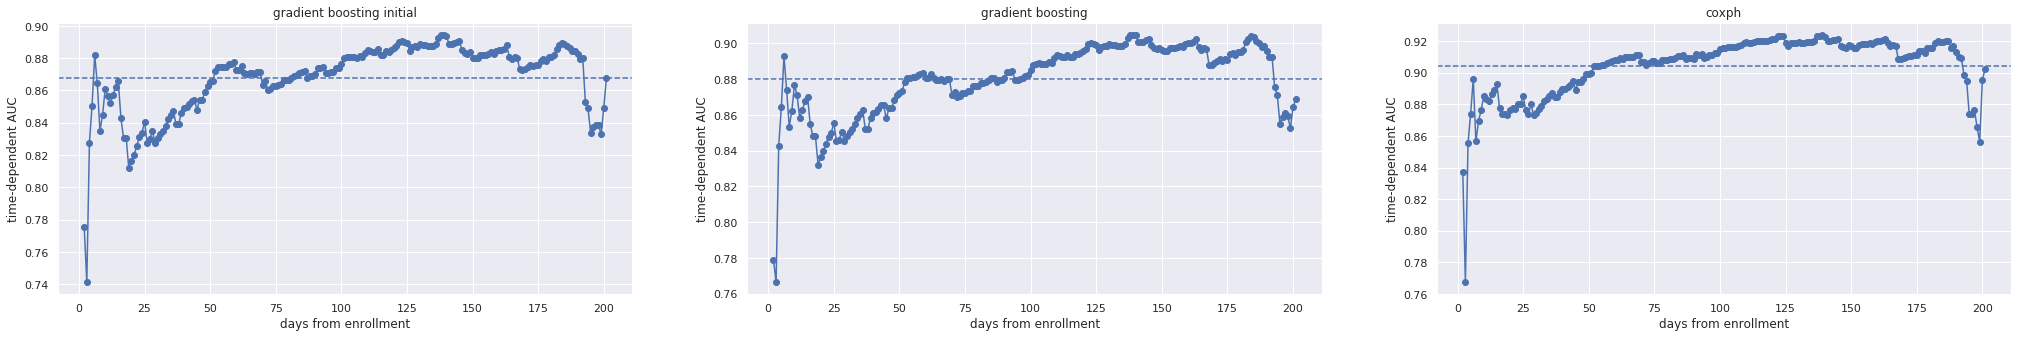

In [134]:
f, ax = plt.subplots(1, 3, figsize=(35, 5), sharex='row')
plot_dynamic_auc(y_train, y_test, prediction_gbs_,range(202), ax[0], "gradient boosting initial")
plot_dynamic_auc(y_train, y_test, prediction_gbs,range(202), ax[1], "gradient boosting")
plot_dynamic_auc(y_train, y_test, prediction_cox,range(202), ax[2], "coxph")

* like for the models with there is a difference in models' performance between midle and extrmities time range  
the traditional cox model is still the best followed by the the tuned gradient boosting  

* All the performance indicators for allmodel have decreased with the inclusion of nutritional data  
this suggest that there is more noise in the data, which reduce the the capability of the models to diferenciate dead persons from alive ones

In [135]:
feature_names = train_encoded.columns[:-2].tolist()
perm = PermutationImportance(coxph, n_iter=15, random_state=rand_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

here we surprisingly see that top 10 feature we have seven, this suggest how important is the nutritional data for CVD prediction 

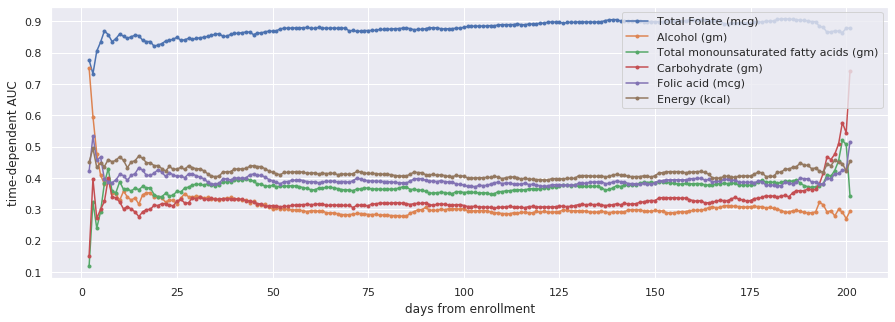

In [137]:
features =("Total Folate (mcg)","Alcohol (gm)", "Total monounsaturated fatty acids (gm)", "Carbohydrate (gm)","Folic acid (mcg)", "Energy (kcal)")
plt.figure(figsize=(15, 5))
for i, col in enumerate(features):
    plot_cumulative_dynamic_auc(X_test[:, i], col)
    ret = concordance_index_ipcw(y_train, y_test, X_test[:, i], tau=range(202)[-1])